In [335]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [336]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import requests
import numpy as np

In [337]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [338]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Handle TotalCharges: convert to numeric, fill NaN with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn'].map({'Yes':1, 'No':0})
y = y.to_numpy()

positive_samples = (y == 1).sum().item()
negative_samples = (y == 0).sum().item()
pos_weight = negative_samples / positive_samples

# Separate categorical and numerical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

X = preprocessor.fit_transform(X)

X = X.astype(np.float32)# Ensure X is float32

In [339]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [340]:
class CustomDataset(Dataset):
    def __init__(self):
        self.y = y
        self.X = X


    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [341]:
dataset = CustomDataset()
type(dataset)

__main__.CustomDataset

In [342]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, lengths=[train_size, test_size])

len(train_dataset), len(test_dataset)

(5634, 1409)

In [343]:
type(train_dataset[0][0])

torch.Tensor

In [344]:
BS = 64
train_dataset = DataLoader(train_dataset, batch_size=BS)
test_dataset = DataLoader(test_dataset, batch_size=BS)

len(train_dataset), len(test_dataset)

(89, 23)

In [345]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(46, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drp1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drp2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.drp3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(256, 1)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Does not apply sigmoid
        Returns raw logits
        """
        x = self.relu(self.drp1(self.bn1(self.fc1(x))))
        x = self.relu(self.drp2(self.bn2(self.fc2(x))))
        x = self.relu(self.drp3(self.bn3(self.fc3(x))))
        x = self.fc4(x)

        return x

In [346]:
model = Model()
model.to(device)
model.train()

MAX_EPOCH = 100
LR = 0.001

optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32))

In [347]:
URL = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'

response = requests.get(URL)

with open('helper_functions.py', 'wb') as f:
    f.write(response.content)

In [348]:
from helper_functions import accuracy_fn

In [349]:
threshold = 0.7
loss_difference = 0.01

In [350]:
losses = []
epochs = []

all_probs = []
all_labels = []

for epoch in range(MAX_EPOCH):
    train_loss = 0

    for batch, (X,y) in enumerate(train_dataset):
        X = X.to(device)
        y = y.to(device)
        X = X.float()

        y_pred_logits = model.forward(X)

        # y_pred_label= torch.round(torch.sigmoid(y_pred_logits))
        prob = torch.sigmoid(y_pred_logits)
        
        all_probs.append(prob.detach().cpu().numpy())
        y_pred_label = (prob >= threshold).int()

        y_true = y
        all_labels.append(y_true.cpu().numpy())

        loss = loss_fn(y_pred_logits.squeeze(1), y_true.float())
        train_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(train_dataset)
    losses.append(train_loss.cpu().detach().numpy())
    epochs.append(epoch+1)

    # check if need to stop training. Check if loss stops declining
    if epoch >= 5:
        last_five_epochs = [
            losses[epoch-4], losses[epoch-3], losses[epoch-2], losses[epoch-1], losses[epoch]
        ]
        if (last_five_epochs[0] - last_five_epochs[1]) < loss_difference and \
           (last_five_epochs[1] - last_five_epochs[2]) < loss_difference and \
           (last_five_epochs[2] - last_five_epochs[3]) < loss_difference and \
           (last_five_epochs[3] - last_five_epochs[4]) < loss_difference:
            break


    print(f'Epoch: {epoch+1}, Loss: {train_loss:.4f}')

all_probs = np.concatenate(all_probs).reshape(-1, 1)
all_labels = np.concatenate(all_labels)

Epoch: 1, Loss: 0.7643
Epoch: 2, Loss: 0.7163
Epoch: 3, Loss: 0.7053
Epoch: 4, Loss: 0.6950
Epoch: 5, Loss: 0.6846
Epoch: 6, Loss: 0.6757
Epoch: 7, Loss: 0.6640
Epoch: 8, Loss: 0.6591
Epoch: 9, Loss: 0.6512
Epoch: 10, Loss: 0.6397
Epoch: 11, Loss: 0.6375
Epoch: 12, Loss: 0.6263
Epoch: 13, Loss: 0.6162
Epoch: 14, Loss: 0.6088
Epoch: 15, Loss: 0.5963
Epoch: 16, Loss: 0.5929
Epoch: 17, Loss: 0.5773
Epoch: 18, Loss: 0.5789
Epoch: 19, Loss: 0.5634
Epoch: 20, Loss: 0.5502
Epoch: 21, Loss: 0.5449
Epoch: 22, Loss: 0.5447
Epoch: 23, Loss: 0.5297
Epoch: 24, Loss: 0.5296
Epoch: 25, Loss: 0.5101
Epoch: 26, Loss: 0.5195
Epoch: 27, Loss: 0.5064
Epoch: 28, Loss: 0.4939
Epoch: 29, Loss: 0.4885
Epoch: 30, Loss: 0.4868
Epoch: 31, Loss: 0.4715
Epoch: 32, Loss: 0.4553
Epoch: 33, Loss: 0.4654
Epoch: 34, Loss: 0.4641
Epoch: 35, Loss: 0.4536
Epoch: 36, Loss: 0.4284
Epoch: 37, Loss: 0.4356
Epoch: 38, Loss: 0.4277
Epoch: 39, Loss: 0.4279
Epoch: 40, Loss: 0.4128
Epoch: 41, Loss: 0.4232
Epoch: 42, Loss: 0.4165
E

In [351]:
calibrator = LogisticRegression()
calibrator.fit(all_probs, all_labels)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [352]:
# losses

Text(0.5, 1.0, 'Loss Curves')

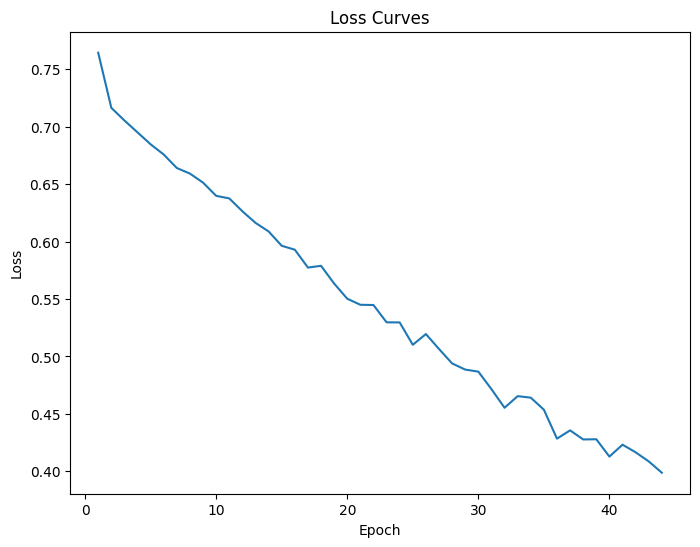

In [353]:

plt.figure(figsize=(8, 6))
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')


In [ ]:
model.eval()

with torch.inference_mode():
    test_loss = 0
    total_churners = 0
    churners_caught = 0

    total = 0
    correct = 0

    non_churners_flagged = 0
    non_churners = 0

    for X,y in test_dataset:
        X = X.to(device).float()
        y = y.to(device)

        y_pred_logits = model.forward(X).squeeze(1)
        prob = torch.sigmoid(y_pred_logits)
        calibrated_prob = calibrator.predict_proba(prob.detach().numpy().reshape(-1, 1))[:, 1]

        # y_pred_label = (calibrated_prob >= threshold).int()
        y_pred_label = torch.tensor(calibrated_prob >= 0.05, dtype=torch.float32)
        y_true = y

        loss = loss_fn(y_pred_logits, y_true.float())
        test_loss += loss.item()

        total_churners += y_true.sum().item()
        # print(type(y_true))
        # print(type(y_pred_label))
        y_true = y_true.to(torch.int)
        y_pred_label=y_pred_label.to(torch.int)

        churners_caught += (y_true & y_pred_label).sum().int().item()

        total += len(y_true)
        correct += torch.eq(y_true, y_pred_label).sum().item()

        


        # print(churners_caught)

        non_churners += (y_true == 0).sum().item()
        non_churners_flagged += ((y_true == 0) & (y_pred_label == 1)).sum().item()
        

    test_loss /= len(test_dataset)

    # print(total_churners)
    # print(churners_caught)

    caught_acc = 100 * (churners_caught / total_churners)
    acc = 100 * (correct / total)

    print(f'Loss: {test_loss:.3f}, Churners Caught Acc: {caught_acc:.2f}%')
    print(f'Non-churners flagged as churners: {non_churners_flagged} out of {non_churners}, which is {100 * (non_churners_flagged / non_churners):.2f}%')
    print(f'Loss: {test_loss:.3f}, Acc: {acc:.2f}%')

Loss: 1.267, Churners Caught Acc: 100.00%
Non-churners flagged as churners: 1036 out of 1036, which is 100.00%
Loss: 1.267, Acc: 26.47%
